# Smile Detection Model


In [ ]:
# Mount the drive for file upload
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset used comes from: https://www.kaggle.com/iarunava/happy-house-dataset


### Library Imports


In [ ]:
# Dataset Location on Google Drive
train_loc = '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/train_happy.h5'
test_loc = '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/test_happy.h5'

In [ ]:
## Library Imports 
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from numpy.random import seed
import h5py
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


### Loading the Dataset

In [ ]:
def load_dataset(path_to_train, path_to_test):
  """ Function used to extract the image and labels from the h5 files. 
      The training set will need to be further split into a validation set. 
  """
  train_dataset = h5py.File(path_to_train)
  train_x = np.array(train_dataset['train_set_x'][:])
  train_y = np.array(train_dataset['train_set_y'][:])

  test_dataset = h5py.File(path_to_test)
  test_x = np.array(test_dataset['test_set_x'][:])
  test_y = np.array(test_dataset['test_set_y'][:])

  # y reshaped
  train_y = train_y.reshape((1, train_x.shape[0]))
  test_y = test_y.reshape((1, test_y.shape[0]))

  return train_x, train_y, test_x, test_y

In [ ]:
train_x, train_y, test_x, test_y = load_dataset(train_loc, test_loc)

### Data Augmentation

When there's not enough data, you can apply data augmentation techniques. Anything like rotating the original image by a small angle and/or flipping the image horizontally can increase the diversity of your dataset and decrease overfitting. 

In [ ]:
def augment_an_image(image, label, num_times):
  """ Given an image, the returned image will be the original flipped and/or rotated randomly. 
      Images come in as (64, 64, 3) but this function requires (1, 64, 64, 3). 
      To match the required shape, we will add a dimension to the image arrays within this function. 
  """
  data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
  )
  reshaped_image = np.expand_dims(image, 0)
  augmented_images = [data_augmentation(reshaped_image) for i in range(num_times)]
  image = np.expand_dims(image,0)
  image = np.expand_dims(image,0)
  returned_images = np.concatenate((image, augmented_images))
  return returned_images, np.asarray([label for i in range(num_times+1)]).reshape((1,1+num_times))

def augment_all_images(images_all, labels_all, num_times):
  """ Applies data augmentation techniques to each image in the images_all dataset
      and generates the labels to match the generated images respectively. 
      Calls the "augment_an_image" function on each image in images_all. 
      The generated numpy arrays are concatenated to create a new array holding both
      the original and augmented images and their respective labels. 
      images_all and labels_all has to be of the same set of data:
        ex. images_all = train_x, labels_all = train_y
  """
  num_images = len(images_all)
  aug_images_all = None
  aug_labels_all = None
  for i in range(num_images):
    aug_images, aug_labels = augment_an_image(images_all[i], labels_all[0][i], num_times)
    if aug_images_all is None:
      aug_images_all = aug_images
      aug_labels_all = aug_labels[0]
    else: 
      aug_images_all = np.concatenate((aug_images_all, aug_images))
      aug_labels_all = np.concatenate((aug_labels_all, aug_labels[0]))
  
  # Reshape to a (1, _) for labels 
  aug_labels_all = np.expand_dims(aug_labels_all,0)
  print("The old image data shape was: {} and is now: {}".format(images_all.shape, aug_images_all.shape))
  print("The old image label shape was: {} and is now: {}".format(labels_all.shape, aug_labels_all.shape))
  return aug_images_all, aug_labels_all

def plot_image_4Dto3D(image, label):
  """ Converts image shape (1, 64, 64, 3) to (64, 64, 3) so matplotlib works. 
      Function using matplotlib to display numpy array as images. 
  """
  image = np.squeeze(image)
  plt.figure(figsize=(5, 5))
  plt.imshow(image)
  plt.title("Label: {}".format(label))
  plt.axis("off")
  plt.show()

def plot_images(images_all, labels_all, num_plot, start=0):
  """ For plotting a desired number (num_plot) of images from a dataset. 
      A "start" index can be chosen to start later in the list. 
  """
  if (start+num_plot) > len(images_all):
    return "You're index will go out of range."
  for i in range(num_plot):
    plot_image_4Dto3D(images_all[start+i], labels_all[0][start+i])

def plot_images_categorical(images_all, labels_all, num_plot, start=0):
  """ Same function as plot_images but deals with labels that are one-hot categorical. 
  """
  if (start+num_plot) > len(images_all):
    return "You're index will go out of range."
  
  for i in range(num_plot):
    if np.allclose(labels_all[i+start], np.array([1., 0.])):
      plot_image_4Dto3D(images_all[start+i], 0)
    elif np.allclose(labels_all[i+start], np.array([0., 1.])):
      plot_image_4Dto3D(images_all[start+i], 1)
    else:
      return "That's not a valid label..."

#### Testing Data Augmentation

In [ ]:
new_train_x, new_train_y = augment_all_images(train_x, train_y, 3)

The old image data shape was: (600, 64, 64, 3) and is now: (2400, 1, 64, 64, 3)
The old image label shape was: (1, 600) and is now: (1, 2400)


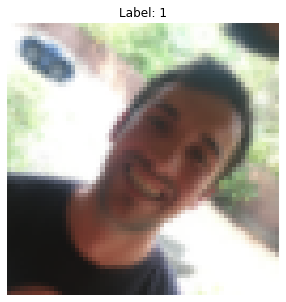

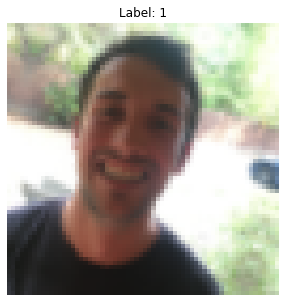

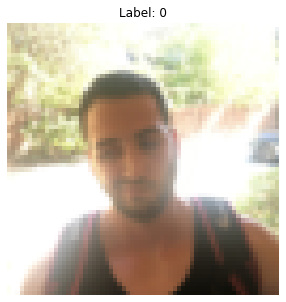

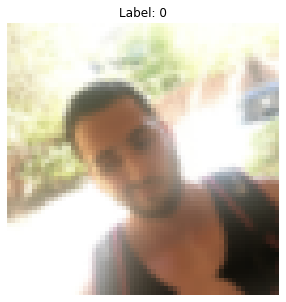

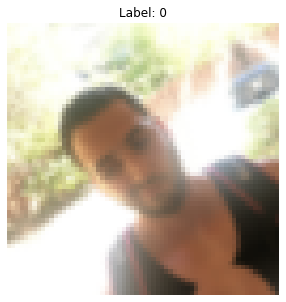

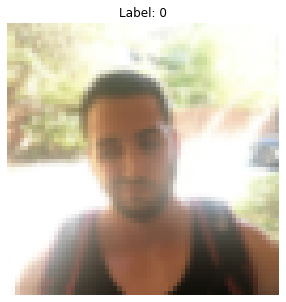

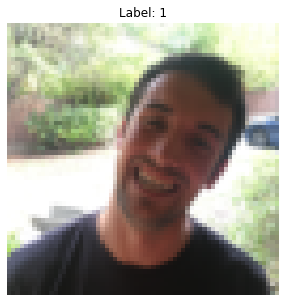

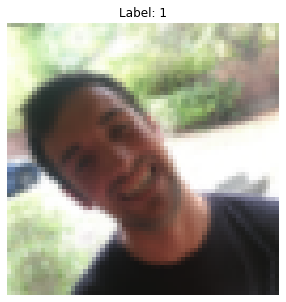

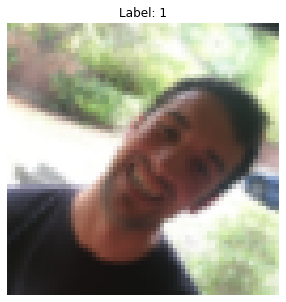

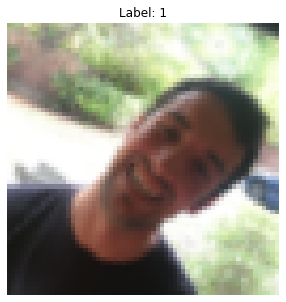

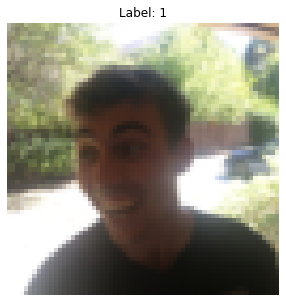

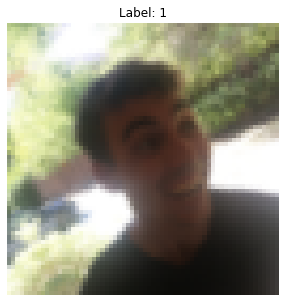

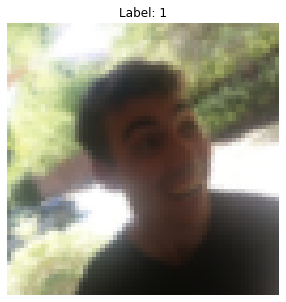

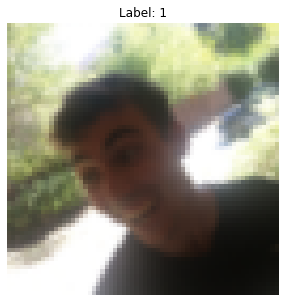

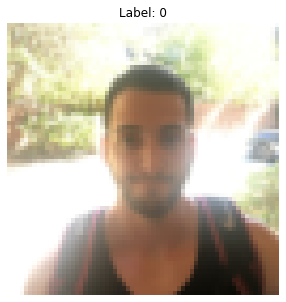

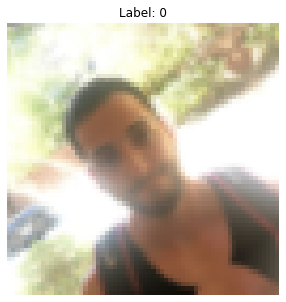

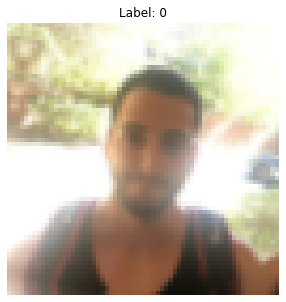

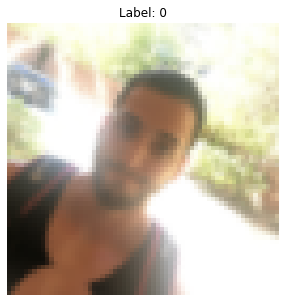

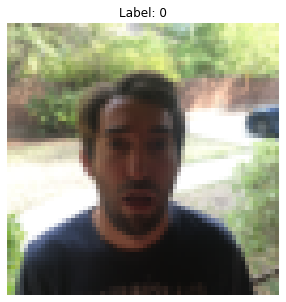

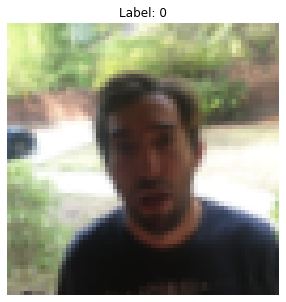

In [ ]:
plot_images(new_train_x, new_train_y, 20, 354)

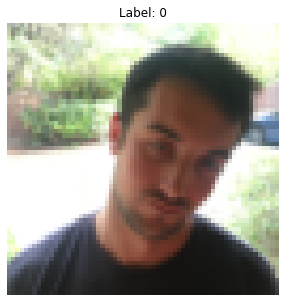

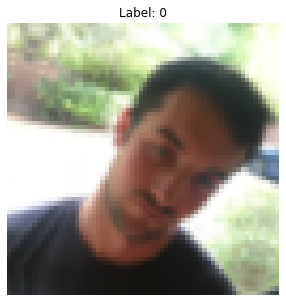

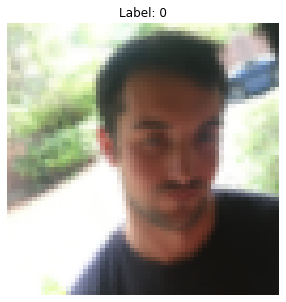

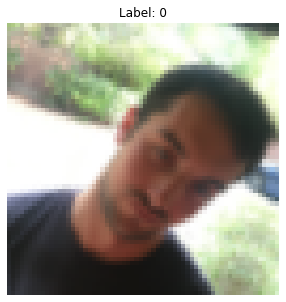

In [ ]:
augmented_images, matching_labels = augment_an_image(train_x[0], train_y[0][0], 3)
for item in augmented_images:
  plot_image_4Dto3D(item, 0)

### Train-Test Split

In [ ]:
seed(88)
tf.random.set_seed(88)
def generate_traintestsplit(images_all, labels_all):
    """ Uses train_test_split to generate and randomize our training and testing dataset. 
        Labels are also converted to categorical one-hot encodings. 
    """
    print("Performing the train/test split...")
    one_hot_encoded_labels = to_categorical(labels_all[0])
    x_train, x_test, y_train, y_test = train_test_split(images_all, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = 88)
    print("Shapes: x_train - {}, y_train - {}, x_test - {}, y_test - {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = generate_traintestsplit(new_train_x, new_train_y)

Performing the train/test split...
Shapes: x_train - (1920, 1, 64, 64, 3), y_train - (1920, 2), x_test - (480, 1, 64, 64, 3), y_test - (480, 2)


We can use h5py to save the newly generated dataset! 

In [ ]:
def name_h5(name):
  """ h5 file save naming convention. """
  return '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/{}.h5'.format(name)

In [ ]:
# Run this only once to create the h5 file that stores the new augmented dataset
with h5py.File(name_h5('augmented_dataset'), "w") as f:
  dset1 = f.create_dataset("x_train", data=x_train)
  dset2 = f.create_dataset("x_test", data=x_test)
  dset3 = f.create_dataset("y_train", data=y_train)
  dset4 = f.create_dataset("y_test", data=y_test)

In [ ]:
# Use this to check how you can access the numpy arrays within the h5 file. 
filename = name_h5('augmented_dataset')

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['x_test', 'x_train', 'y_test', 'y_train']>


In [ ]:
# Access the File
augmented_dataset = h5py.File(name_h5('augmented_dataset'))

# Load data into variables for use
x_train = np.array(augmented_dataset['x_train'][:])
y_train = np.array(augmented_dataset['y_train'][:])
x_test = np.array(augmented_dataset['x_test'][:])
y_test = np.array(augmented_dataset['y_test'][:])


In [ ]:
print(x_train.shape, type(x_train))
print(y_train.shape, type(y_train))
print(x_test.shape, type(x_test))
print(y_test.shape, type(y_test))

(1920, 1, 64, 64, 3) <class 'numpy.ndarray'>
(1920, 2) <class 'numpy.ndarray'>
(480, 1, 64, 64, 3) <class 'numpy.ndarray'>
(480, 2) <class 'numpy.ndarray'>


### ~~ All data preprocessing code together 

In [ ]:
## Dataset Location on Google Drive
train_loc = '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/train_happy.h5'
test_loc = '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/test_happy.h5'

## Library Imports 
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from numpy.random import seed
import h5py
import cv2
import datetime as dt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def load_dataset(path_to_train, path_to_test):
  """ Function used to extract the image and labels from the h5 files. 
      The training set will need to be further split into a validation set. 
  """
  train_dataset = h5py.File(path_to_train)
  train_x = np.array(train_dataset['train_set_x'][:])
  train_y = np.array(train_dataset['train_set_y'][:])

  test_dataset = h5py.File(path_to_test)
  test_x = np.array(test_dataset['test_set_x'][:])
  test_y = np.array(test_dataset['test_set_y'][:])

  # y reshaped
  train_y = train_y.reshape((1, train_x.shape[0]))
  test_y = test_y.reshape((1, test_y.shape[0]))

  return train_x, train_y, test_x, test_y

def augment_an_image(image, label, num_times):
  """ Given an image, the returned image will be the original flipped and/or rotated randomly. 
      Images come in as (64, 64, 3) but this function requires (1, 64, 64, 3). 
      To match the required shape, we will add a dimension to the image arrays within this function. 
  """
  data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
  )
  reshaped_image = np.expand_dims(image, 0)
  augmented_images = [data_augmentation(reshaped_image) for i in range(num_times)]
  image = np.expand_dims(image,0)
  image = np.expand_dims(image,0)
  returned_images = np.concatenate((image, augmented_images))
  return returned_images, np.asarray([label for i in range(num_times+1)]).reshape((1,1+num_times))

def augment_all_images(images_all, labels_all, num_times):
  """ Applies data augmentation techniques to each image in the images_all dataset
      and generates the labels to match the generated images respectively. 
      Calls the "augment_an_image" function on each image in images_all. 
      The generated numpy arrays are concatenated to create a new array holding both
      the original and augmented images and their respective labels. 
      images_all and labels_all has to be of the same set of data:
        ex. images_all = train_x, labels_all = train_y
  """
  num_images = len(images_all)
  aug_images_all = None
  aug_labels_all = None
  for i in range(num_images):
    aug_images, aug_labels = augment_an_image(images_all[i], labels_all[0][i], num_times)
    if aug_images_all is None:
      aug_images_all = aug_images
      aug_labels_all = aug_labels[0]
    else: 
      aug_images_all = np.concatenate((aug_images_all, aug_images))
      aug_labels_all = np.concatenate((aug_labels_all, aug_labels[0]))
  
  # Reshape to a (1, _) for labels 
  aug_labels_all = np.expand_dims(aug_labels_all,0)
  print("The old image data shape was: {} and is now: {}".format(images_all.shape, aug_images_all.shape))
  print("The old image label shape was: {} and is now: {}".format(labels_all.shape, aug_labels_all.shape))
  return aug_images_all, aug_labels_all

def generate_traintestsplit(images_all, labels_all):
    """ Uses train_test_split to generate and randomize our training and testing dataset. 
        Labels are also converted to categorical one-hot encodings. 
    """
    print("Performing the train/test split...")
    one_hot_encoded_labels = to_categorical(labels_all[0])
    x_train, x_test, y_train, y_test = train_test_split(images_all, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = 88)
    print("Shapes: x_train - {}, y_train - {}, x_test - {}, y_test - {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))
    return x_train, x_test, y_train, y_test

def name_h5(name):
  """ h5 file save naming convention. """
  return '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/{}.h5'.format(name)

def gen_augmented_traintestsplit(path_to_train, path_to_test, aug_num_times, save_name, save = False):
  """ This function will call all the above functions :D, so just call this one. 
      We will first combine the given test and training sets to augment all of it.
      We will then generate a new train_test_split at a 8:2 ratio of training:test.

      Inputs:  
        aug_num_times (integer) - how many times we want to augment each image
        save_name (string) - what do we call the saved h5 file? 
        save (True or False) - Do we want to save the h5 file? 
  """
  # Load original dataset
  train_x, train_y, test_x, test_y = load_dataset(path_to_train, path_to_test)

  # Combine training and test sets for augmentation
  new_train_x = np.vstack((train_x, test_x))
  new_train_y = np.hstack((train_y, test_y))

  # Perform data augmentation
  aug_images_all, aug_labels_all = augment_all_images(new_train_x, new_train_y, aug_num_times)

  # Perform train_test_split
  x_train, x_test, y_train, y_test = generate_traintestsplit(aug_images_all, aug_labels_all)

  # Optional Save to Database 
  if save == True:
    with h5py.File(name_h5(save_name), "w") as f:
      dset1 = f.create_dataset("x_train", data=x_train)
      dset2 = f.create_dataset("x_test", data=x_test)
      dset3 = f.create_dataset("y_train", data=y_train)
      dset4 = f.create_dataset("y_test", data=y_test)

  return x_train, x_test, y_train, y_test

def import_my_h5_data(save_name):
  """ Used to access the saved h5 file data. 
      Input:  
        save_name (string)
  """
  # Access the File
  augmented_dataset = h5py.File(name_h5(save_name))

  # Load data into variables for use
  x_train = np.array(augmented_dataset['x_train'][:])
  y_train = np.array(augmented_dataset['y_train'][:])
  x_test = np.array(augmented_dataset['x_test'][:])
  y_test = np.array(augmented_dataset['y_test'][:])

  x_train = np.squeeze(x_train)
  x_test = np.squeeze(x_test)

  print("x_train shape and type are: {} and {}".format(x_train.shape, type(x_train)))
  print("y_train shape and type are: {} and {}".format(y_train.shape, type(y_train)))
  print("x_test shape and type are: {} and {}".format(x_test.shape, type(x_test)))
  print("y_test shape and type are: {} and {}".format(y_test.shape, type(y_test)))

  return x_train, x_test, y_train, y_test

def plot_image_4Dto3D(image, label):
  """ Converts image shape (1, 64, 64, 3) to (64, 64, 3) so matplotlib works. 
      Function using matplotlib to display numpy array as images. 
  """
  image = np.squeeze(image)
  plt.figure(figsize=(5, 5))
  plt.imshow(image)
  plt.title("Label: {}".format(label))
  plt.axis("off")
  plt.show()

def plot_images(images_all, labels_all, num_plot, start=0):
  """ For plotting a desired number (num_plot) of images from a dataset. 
      A "start" index can be chosen to start later in the list. 
  """
  if (start+num_plot) > len(images_all):
    return "You're index will go out of range."
  for i in range(num_plot):
    plot_image_4Dto3D(images_all[start+i], labels_all[0][start+i])

def plot_images_categorical(images_all, labels_all, num_plot, start=0):
  """ Same function as plot_images but deals with labels that are one-hot categorical. 
  """
  if (start+num_plot) > len(images_all):
    return "You're index will go out of range."
  
  for i in range(num_plot):
    if np.allclose(labels_all[i+start], np.array([1., 0.])):
      plot_image_4Dto3D(images_all[start+i], 0)
    elif np.allclose(labels_all[i+start], np.array([0., 1.])):
      plot_image_4Dto3D(images_all[start+i], 1)
    else:
      return "That's not a valid label..."

In [ ]:
# Generate Dataset 
__, __, __, __ = gen_augmented_traintestsplit(train_loc, test_loc, 3, 'Olympics', save = True)

The old image data shape was: (750, 64, 64, 3) and is now: (3000, 1, 64, 64, 3)
The old image label shape was: (1, 750) and is now: (1, 3000)
Performing the train/test split...
Shapes: x_train - (2400, 1, 64, 64, 3), y_train - (2400, 2), x_test - (600, 1, 64, 64, 3), y_test - (600, 2)


In [ ]:
# Load Dataset from Storage
x_train, x_test, y_train, y_test = import_my_h5_data('Olympics')

x_train shape and type are: (2400, 64, 64, 3) and <class 'numpy.ndarray'>
y_train shape and type are: (2400, 2) and <class 'numpy.ndarray'>
x_test shape and type are: (600, 64, 64, 3) and <class 'numpy.ndarray'>
y_test shape and type are: (600, 2) and <class 'numpy.ndarray'>


In [ ]:
print(y_train[:10])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


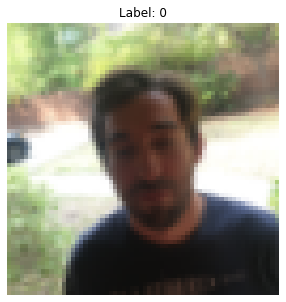

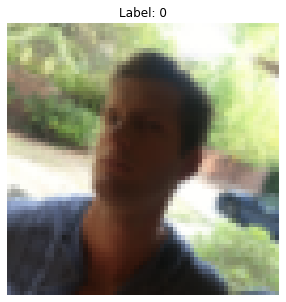

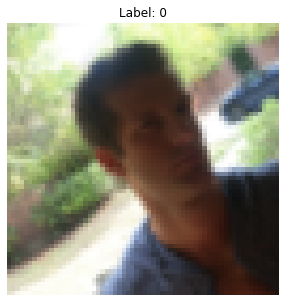

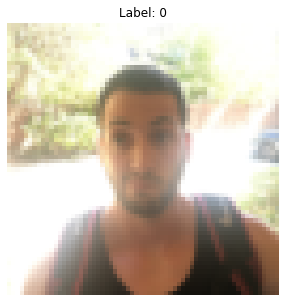

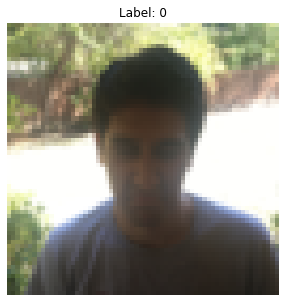

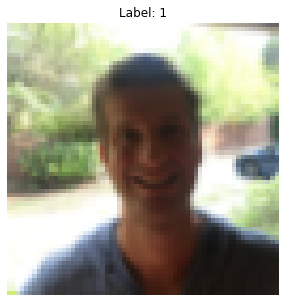

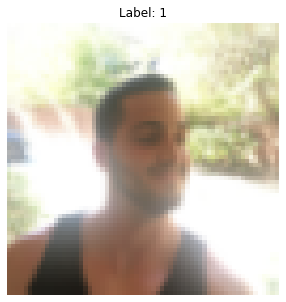

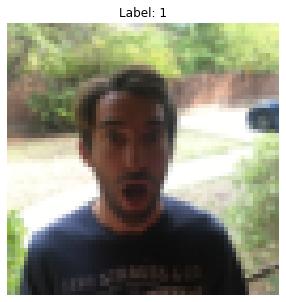

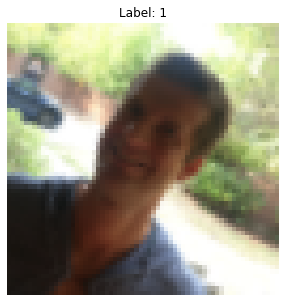

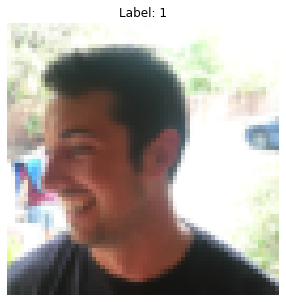

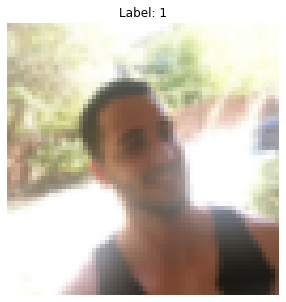

In [ ]:
# Visualize the Database
# Label: 1 are smiles and Label: 0 are not smiles
plot_images_categorical(x_train, y_train, 11, 0)

### Standardizing the Data

For ideal training conditions, the RGB values of each pixel in each image should be normalized to a value between 0 and 1. Currently, the range is 0 to 255. For optimal GPU performance, we will perform standardization within the model itself. 

In [ ]:
print(new_train_x[0][0][25][25])

[172  86  75]


### Model Evaluation using Keras

#### Baseline Model


In [ ]:
def gen_model(num_classes, x_train, y_train, x_test, y_test, epoch = 10, batch_size=16, verbose=2, channels=3):
  """ The images will be standardized with their RGB channel values rescaled 
      from the [0, 255] range to [0, 1] range. A standard image classification
      model will be used as the baseline model for comparison. 
  """
  img_height = x_train.shape[1]
  img_width = x_train.shape[2]

  model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'sigmoid')
  ])

  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
  model.summary()

  # Fit the Model
  early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
  training_history = model.fit(x = x_train, y = y_train, epochs = epoch, batch_size = batch_size, verbose = verbose, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])  
  plot_results(training_history)

  # Evaluate the Model
  evaluation_history = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = verbose)

  print("Test Accuracy is: {}".format(evaluation_history[1]*100))
  print("Test Loss is: {}".format(evaluation_history[0]))
  return model, evaluation_history 

def plot_results(training_history):
  """ For visuals. """
  train_loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  train_accuracy = training_history.history['accuracy']
  val_accuracy = training_history.history['val_accuracy']

  num_epochs = range(len(train_loss))

  plt.figure(1)
  plt.plot(num_epochs, train_loss, label = 'train_loss')
  plt.plot(num_epochs, val_loss, label = 'val_loss')
  plt.title("Training vs Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.figure(2)
  plt.plot(num_epochs, train_accuracy, label = 'train_accuracy')
  plt.plot(num_epochs, val_accuracy, label = 'val_accuracy')
  plt.title("Training vs Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.show()

def generate_name_for_saving(evaluation_history):
  """ To make a default naming convention for saving model configurations. """
  date_time_formatting = "%Y_%m_%d"
  current_time = dt.datetime.now()
  str_current_time = dt.datetime.strftime(current_time, date_time_formatting)

  model_eval_loss, model_eval_accuracy = evaluation_history
  model_name = '/Model__Date_{}__Loss_{}__Accuracy_{}.h5'.format(str_current_time, round(model_eval_loss, 2), round(model_eval_accuracy, 2))
  return model_name

def save_model(model, evaluation_history, save_loc):
  model_name = generate_name_for_saving(evaluation_history)
  model.save(save_loc + model_name)

def load_model(model_name, save_loc):
  model = keras.models.load_model(save_loc + model_name)
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0

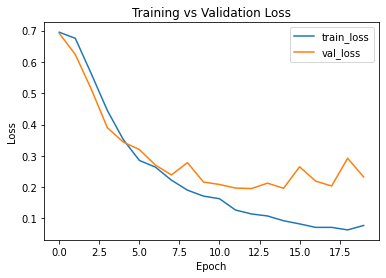

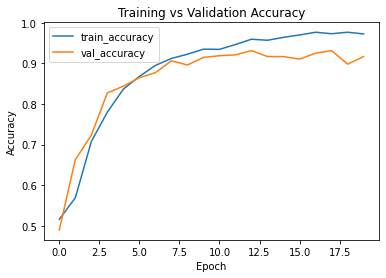

38/38 - 3s - loss: 0.1974 - accuracy: 0.9367
Test Accuracy is: 93.66666674613953
Test Loss is: 0.19740533828735352


In [ ]:
# Train the Model: batch_size 16, learning_rate 1e-3, 
my_model, evaluation_history = gen_model(2, x_train, y_train, x_test, y_test, epoch = 20)

In [ ]:
# Save the model
save_loc = '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/Model_Saves/'
save_model(my_model, evaluation_history, save_loc)

In [ ]:
# Load the saved model
model_name = 'Model__Time_2021_07_31__Loss_0.2__Accuracy_0.94.h5'
my_model = load_model(model_name, save_loc)

With the baseline model, it seems a simple CNN is not complex enough to find any useful features in the data. We will need a more complex model. 

#### Model V2


In [ ]:
def gen_model_v2(x_train, y_train, x_test, y_test, epoch = 10, batch_size=16, learning_rate = 1e-3, verbose=2):
  """ The images will be standardized with their RGB channel values rescaled 
      from the [0, 255] range to [0, 1] range. A standard image classification
      model will be used as the baseline model for comparison. 
  """
  img_height = x_train.shape[1]
  img_width = x_train.shape[2]

  model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(160, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(80, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(40, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation = 'sigmoid')
  ])

  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
  model.summary()

  print("Batch Size: {}, Learning Rate: {}, Epoch: {}".format(batch_size, learning_rate, epoch))

  # Fit the Model
  early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
  training_history = model.fit(x = x_train, y = y_train, epochs = epoch, batch_size = batch_size, verbose = verbose, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])  
  plot_results(training_history)

  # Evaluate the Model
  evaluation_history = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = verbose)

  print("Test Accuracy is: {}".format(evaluation_history[1]*100))
  print("Test Loss is: {}".format(evaluation_history[0]))
  return model, evaluation_history 

def plot_results(training_history):
  """ For visuals. """
  train_loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  train_accuracy = training_history.history['accuracy']
  val_accuracy = training_history.history['val_accuracy']

  num_epochs = range(len(train_loss))

  plt.figure(1)
  plt.plot(num_epochs, train_loss, label = 'train_loss')
  plt.plot(num_epochs, val_loss, label = 'val_loss')
  plt.title("Training vs Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.figure(2)
  plt.plot(num_epochs, train_accuracy, label = 'train_accuracy')
  plt.plot(num_epochs, val_accuracy, label = 'val_accuracy')
  plt.title("Training vs Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.show()

def generate_name_for_saving(evaluation_history):
  """ To make a default naming convention for saving model configurations. """
  date_time_formatting = "%Y_%m_%d"
  current_time = dt.datetime.now()
  str_current_time = dt.datetime.strftime(current_time, date_time_formatting)

  model_eval_loss, model_eval_accuracy = evaluation_history
  model_name = '/Model__Date_{}__Loss_{}__Accuracy_{}.h5'.format(str_current_time, round(model_eval_loss, 2), round(model_eval_accuracy, 2))
  return model_name

def save_model(model, evaluation_history, save_loc):
  model_name = generate_name_for_saving(evaluation_history)
  model.save(save_loc + model_name)

def load_model(model_name, save_loc):
  model = keras.models.load_model(save_loc + model_name)
  return model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 160)       4480      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 80)        115280    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 80)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 40)        28840     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 40)         

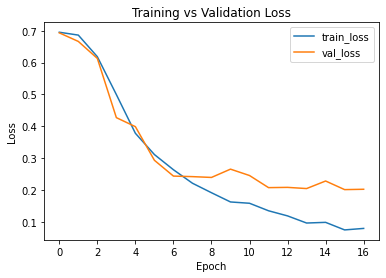

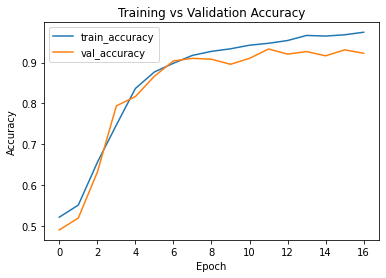

30/30 - 4s - loss: 0.1813 - accuracy: 0.9333
Test Accuracy is: 93.33333373069763
Test Loss is: 0.18132977187633514


In [ ]:
# Train the Model
my_model, evaluation_history = gen_model_v2(x_train, y_train, x_test, y_test, epoch = 17, learning_rate=1e-3, batch_size=20)

#### Model V3

In [ ]:
def gen_model_v3(x_train, y_train, x_test, y_test, epoch = 10, batch_size=16, learning_rate = 1e-3, verbose=2):
  """ The images will be standardized with their RGB channel values rescaled 
      from the [0, 255] range to [0, 1] range. A standard image classification
      model will be used as the baseline model for comparison. 
  """
  img_height = x_train.shape[1]
  img_width = x_train.shape[2]

  model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(160, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(80, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(40, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation = 'sigmoid')
  ])

  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
  model.summary()

  print("Batch Size: {}, Learning Rate: {}, Epoch: {}".format(batch_size, learning_rate, epoch))

  # Fit the Model
  early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
  training_history = model.fit(x = x_train, y = y_train, epochs = epoch, batch_size = batch_size, verbose = verbose, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])  
  plot_results(training_history)

  # Evaluate the Model
  evaluation_history = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = verbose)

  print("Test Accuracy is: {}".format(evaluation_history[1]*100))
  print("Test Loss is: {}".format(evaluation_history[0]))
  return model, evaluation_history 

def plot_results(training_history):
  """ For visuals. """
  train_loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  train_accuracy = training_history.history['accuracy']
  val_accuracy = training_history.history['val_accuracy']

  num_epochs = range(len(train_loss))

  plt.figure(1)
  plt.plot(num_epochs, train_loss, label = 'train_loss')
  plt.plot(num_epochs, val_loss, label = 'val_loss')
  plt.title("Training vs Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.figure(2)
  plt.plot(num_epochs, train_accuracy, label = 'train_accuracy')
  plt.plot(num_epochs, val_accuracy, label = 'val_accuracy')
  plt.title("Training vs Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.show()

def generate_name_for_saving(evaluation_history):
  """ To make a default naming convention for saving model configurations. """
  date_time_formatting = "%Y_%m_%d"
  current_time = dt.datetime.now()
  str_current_time = dt.datetime.strftime(current_time, date_time_formatting)

  model_eval_loss, model_eval_accuracy = evaluation_history
  model_name = '/Model__Date_{}__Loss_{}__Accuracy_{}.h5'.format(str_current_time, round(model_eval_loss, 2), round(model_eval_accuracy, 2))
  return model_name

def save_model(model, evaluation_history, save_loc):
  model_name = generate_name_for_saving(evaluation_history)
  model.save(save_loc + model_name)

def load_model(model_name, save_loc):
  model = keras.models.load_model(save_loc + model_name)
  return model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 160)       4480      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 80)        115280    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 80)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 40)        28840     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 8, 8, 40)        

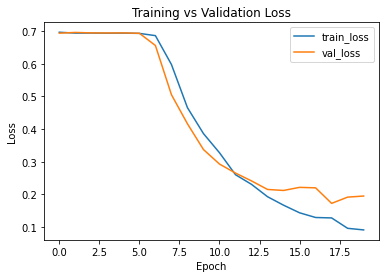

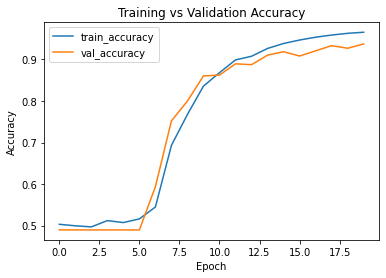

38/38 - 4s - loss: 0.1753 - accuracy: 0.9333
Test Accuracy is: 93.33333373069763
Test Loss is: 0.175309956073761


In [ ]:
# Train the Model
my_model, evaluation_history = gen_model_v3(x_train, y_train, x_test, y_test, epoch = 20, learning_rate=1e-3, batch_size=16)

#### Best Model so Far


In [ ]:
def gen_model_v4(x_train, y_train, x_test, y_test, epoch = 10, batch_size=16, learning_rate = 1e-3, verbose=2):
  """ The images will be standardized with their RGB channel values rescaled 
      from the [0, 255] range to [0, 1] range. A standard image classification
      model will be used as the baseline model for comparison. 
  """
  save_loc = '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/Model_Saves/'
  img_height = x_train.shape[1]
  img_width = x_train.shape[2]

  model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation = 'sigmoid')
  ])

  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
  model.summary()

  print("Batch Size: {}, Learning Rate: {}, Epoch: {}".format(batch_size, learning_rate, epoch))

  # Fit the Model
  mc = ModelCheckpoint(save_loc + 'best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
  early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True, baseline=0.15)
  training_history = model.fit(x = x_train, y = y_train, epochs = epoch, batch_size = batch_size, verbose = verbose, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback, mc])  
  plot_results(training_history)

  # Evaluate the Model
  evaluation_history = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = verbose)

  print("Test Accuracy is: {}".format(evaluation_history[1]*100))
  print("Test Loss is: {}".format(evaluation_history[0]))
  return model, evaluation_history 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 8, 8, 128)       

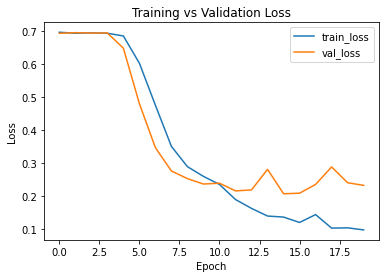

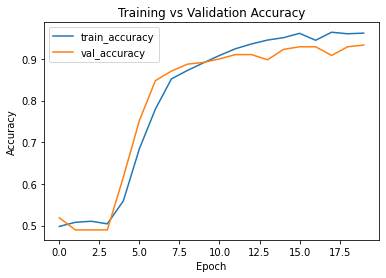

38/38 - 2s - loss: 0.1862 - accuracy: 0.9467
Test Accuracy is: 94.66666579246521
Test Loss is: 0.18620730936527252


In [ ]:
# Train the Model
my_model, evaluation_history = gen_model_v4(x_train, y_train, x_test, y_test, epoch = 20, learning_rate=1e-3, batch_size=16)

In [ ]:
# Save the model
save_loc = '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/Model_Saves/'
save_model(my_model, evaluation_history, save_loc)

In [ ]:
# Load the saved model
model_name = 'Model__Date_2021_08_01__Loss_0.19__Accuracy_0.95.h5'
saved_model = load_model(model_name, save_loc)

In [ ]:
eval_history = saved_model.evaluate(x_test, y_test, batch_size = 16, verbose = 2)

38/38 - 2s - loss: 0.1862 - accuracy: 0.9467


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_19 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 8, 8, 128)       

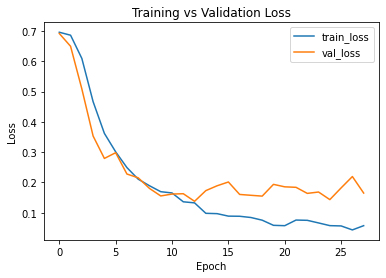

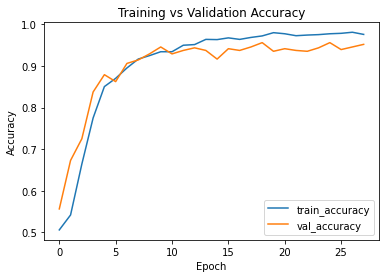

38/38 - 2s - loss: 0.2025 - accuracy: 0.9217
Test Accuracy is: 92.166668176651
Test Loss is: 0.20249269902706146


In [ ]:
my_model, evaluation_history = gen_model_v4(x_train, y_train, x_test, y_test, epoch = 30, learning_rate=1e-3, batch_size=16)

In [ ]:
# Load the saved model
model_name = 'best_model.h5'
saved_model1 = load_model(model_name, save_loc)
eval_history = saved_model1.evaluate(x_test, y_test, batch_size = 16, verbose = 2)

38/38 - 2s - loss: 0.2025 - accuracy: 0.9217


#### Model Tuner

Using KerasTuner to find optimal hyperparameters. 

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 3.8 MB/s 


In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

def model_builder(hp):
  model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (64, 64, 3)),
    layers.Conv2D(filters=hp.Int( 'num_filters_1', min_value=96, max_value=160, step=32, default=128), kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=hp.Int( 'num_filters_2', min_value=48, max_value=80, step=16, default=64), kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=hp.Int( 'num_filters_3', min_value=24, max_value=40, step=8, default=32), kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units=hp.Int('units', min_value=224, max_value=288, step=32, default = 256), activation='relu'),
    layers.Dropout(rate=hp.Float('dropout_1',min_value=0.2,max_value=0.5,default=0.5,step=0.1)),
    layers.Dense(2, activation=hp.Choice( 'dense_activation', values=['sigmoid', 'softmax'], default='sigmoid' ))
  ])
  
  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate',min_value=1e-4,max_value=1e-2,sampling='LOG',default=1e-3)), metrics=['accuracy'])
  return model

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

def model_builder(hp):
  model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (64, 64, 3)),
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units=hp.Int('units', min_value=240, max_value=272, step=8, default = 256), activation='relu'),
    layers.Dropout(rate=hp.Float('dropout_1',min_value=0.4,max_value=0.6,default=0.5,step=0.05)),
    layers.Dense(2, activation='sigmoid')
  ])
  
  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate',min_value=1e-3,max_value=1e-2,sampling='LOG',default=1e-3)), metrics=['accuracy'])
  return model

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

def model_builder(hp):
  model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (64, 64, 3)),
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units=hp.Int('units', min_value=240, max_value=272, step=8, default = 256), activation='relu'),
    layers.Dropout(rate=hp.Float('dropout_1',min_value=0.4,max_value=0.6,default=0.5,step=0.05)),
    layers.Dense(2, activation='sigmoid')
  ])
  
  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train, y_train, epochs=13, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Trial 30 Complete [00h 04m 22s]
val_accuracy: 0.9125000238418579

Best val_accuracy So Far: 0.9145833253860474
Total elapsed time: 00h 59m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
save_loc = '/content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/Model_Saves/'
model.save(save_loc+'keras_tuner1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TBD Name/Image Classification/Smile Detection/Model_Saves/keras_tuner1/assets


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
training_history = model.fit(x = x_train, y = y_train, epochs = 14, batch_size = 1, verbose = 2, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])  
plot_results(training_history)
# Evaluate the Model
evaluation_history = model.evaluate(x_test, y_test, batch_size = 1, verbose = 2)

In [ ]:
save_model(model, evaluation_history, save_loc)

#### Xception Model V1


The next model to try is a small snipet of the Xception network from: https://keras.io/examples/vision/image_classification_from_scratch/ 

In [ ]:
def gen_model_v2(num_classes, x_train, y_train, x_test, y_test, epoch = 10, batch_size=1, verbose=2):
  """ The images will be standardized with their RGB channel values rescaled 
      from the [0, 255] range to [0, 1] range. A standard image classification
      model will be used as the baseline model for comparison. 
  """
  img_height = x_train.shape[1]
  img_width = x_train.shape[2]
  input_shape = (img_height, img_width, 3)

  inputs = keras.Input(shape=input_shape)
  x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

  x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x

  for size in [128, 256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

    x = layers.add([x, residual])
    previous_block_activation = x
  
  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(num_classes, activation = 'sigmoid')(x)
  model = keras.Model(inputs, outputs)

  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])
  #model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(1e-2), metrics=['accuracy'])
  #model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(1e-1), metrics=['accuracy'])
  model.summary()

  # Fit the Model
  early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
  training_history = model.fit(x = x_train, y = y_train, epochs = epoch, batch_size = batch_size, verbose = verbose, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])  
  #training_history = model.fit(x = x_train, y = y_train, epochs = epoch, batch_size = batch_size, verbose = verbose, shuffle = True, validation_split = 0.2)  

  plot_results(training_history)
  # Evaluate the Model
  evaluation_history = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = verbose)
  print("Test Accuracy is: {}".format(evaluation_history[1]*100))
  print("Test Loss is: {}".format(evaluation_history[0]))
  return evaluation_history 

def plot_results(training_history):
  """ For visuals. """
  train_loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  train_accuracy = training_history.history['accuracy']
  val_accuracy = training_history.history['val_accuracy']

  num_epochs = range(len(train_loss))

  plt.figure(1)
  plt.plot(num_epochs, train_loss, label = 'train_loss')
  plt.plot(num_epochs, val_loss, label = 'val_loss')
  plt.title("Training vs Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.figure(2)
  plt.plot(num_epochs, train_accuracy, label = 'train_accuracy')
  plt.plot(num_epochs, val_accuracy, label = 'val_accuracy')
  plt.title("Training vs Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.show()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 64, 64, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 32)   896         rescaling_2[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 32, 32, 32)   128         conv2d_9[0][0]                   
____________________________________________________________________________________________

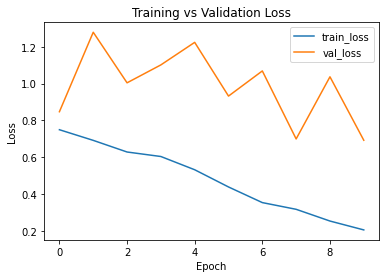

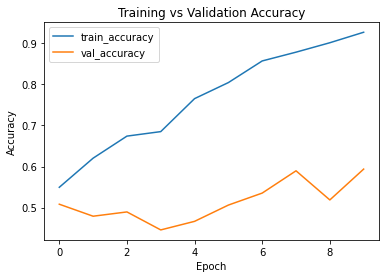

600/600 - 7s - loss: 0.6567 - accuracy: 0.6300
Test Accuracy is: 62.99999952316284
Test Loss is: 0.6567100286483765


In [ ]:
test_history = gen_model_v2(2, x_train, y_train, x_test, y_test)

If the model is still not training properly, then I'm going to look into the data given and see if I generated the data wrong. I might try to print out what the model is predicting to see if they're both making one-hot encodings. 

### Useful Links


https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://www.tensorflow.org/tutorials/images/classification

https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner

https://medium.com/swlh/hand-gestures-using-webcam-and-cnn-convoluted-neural-network-b02c47b3d5ab

https://towardsdatascience.com/drowsiness-detection-using-convolutional-neural-networks-face-recognition-and-tensorflow-56cdfc8315ad
